<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Check-in" data-toc-modified-id="Final-Project-Check-in-1">Final Project Check-in</a></span></li><li><span><a href="#Group-Name" data-toc-modified-id="Group-Name-2">Group Name</a></span></li><li><span><a href="#Student-Names" data-toc-modified-id="Student-Names-3">Student Names</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4">Load Data</a></span></li><li><span><a href="#Fit-scikit-learn-model" data-toc-modified-id="Fit-scikit-learn-model-5">Fit scikit-learn model</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-6">Evaluation Metric</a></span></li></ul></div>

Final Project Check-in
------

Group Name
-----

### Durian Candy 

Student Names
----

1. Andrew Young
2. Charles Siu
3. Sean Tey
4. Sunny Kwong 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import impute
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from rfpimp import *

Load Data
-----

In [2]:
df = pd.read_csv("../data/data_cleaned.csv")

# Replace Categorical Missing Value and Do label encoding
cat_col = ['Nationality', 'Club', 'Preferred_Foot', 'Off_Work_Rate', 
           'Def_Work_Rate', 'Real_Face', 'Position', 'Loaned_Out', 'League_Country', 'League_Country']
df[cat_col] = df[cat_col].fillna(value='NA')  # fill na for categorical features
le = preprocessing.LabelEncoder()
for c in cat_col:
    df[c] = le.fit_transform(df[c])

In [3]:
y = df['Value']

In [4]:
X = df.drop('Value',axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Fit scikit-learn model
----

In [6]:
regressor = RandomForestRegressor(n_estimators=30,
                                  min_samples_leaf=1,
                                  random_state=42)

In [7]:
numerical_col =  list(set(df.columns) - set(cat_col))
numerical_col.remove('Value')

In [8]:
def make_pipeline(regressor=None):
    "Create a single pipeline that processing the data and then fits the regressor." 
    
    median_impute = impute.SimpleImputer(strategy='median')

    numerical_names = numerical_col
    
    col_transform = compose.ColumnTransformer([('numerics',median_impute,numerical_names)])

    steps_list = [('col_t',col_transform),('clf',regressor)]

    pipeline = Pipeline(steps=steps_list)
    
    return pipeline

In [9]:
pipeline = make_pipeline(regressor)

In [10]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('col_t',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerics',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0),
                                                  ['ShotPower', 'FKAccuracy',
                                                   'Acceleration',
                                                   'League_Revenue_Per_Team',

Evaluation Metric
----

In [11]:
y_pred = pipeline.predict(X_test)

In [12]:
median_absolute_error(y_true=y_test,y_pred=y_pred)

0.02199999999999995

Feature Importance
---

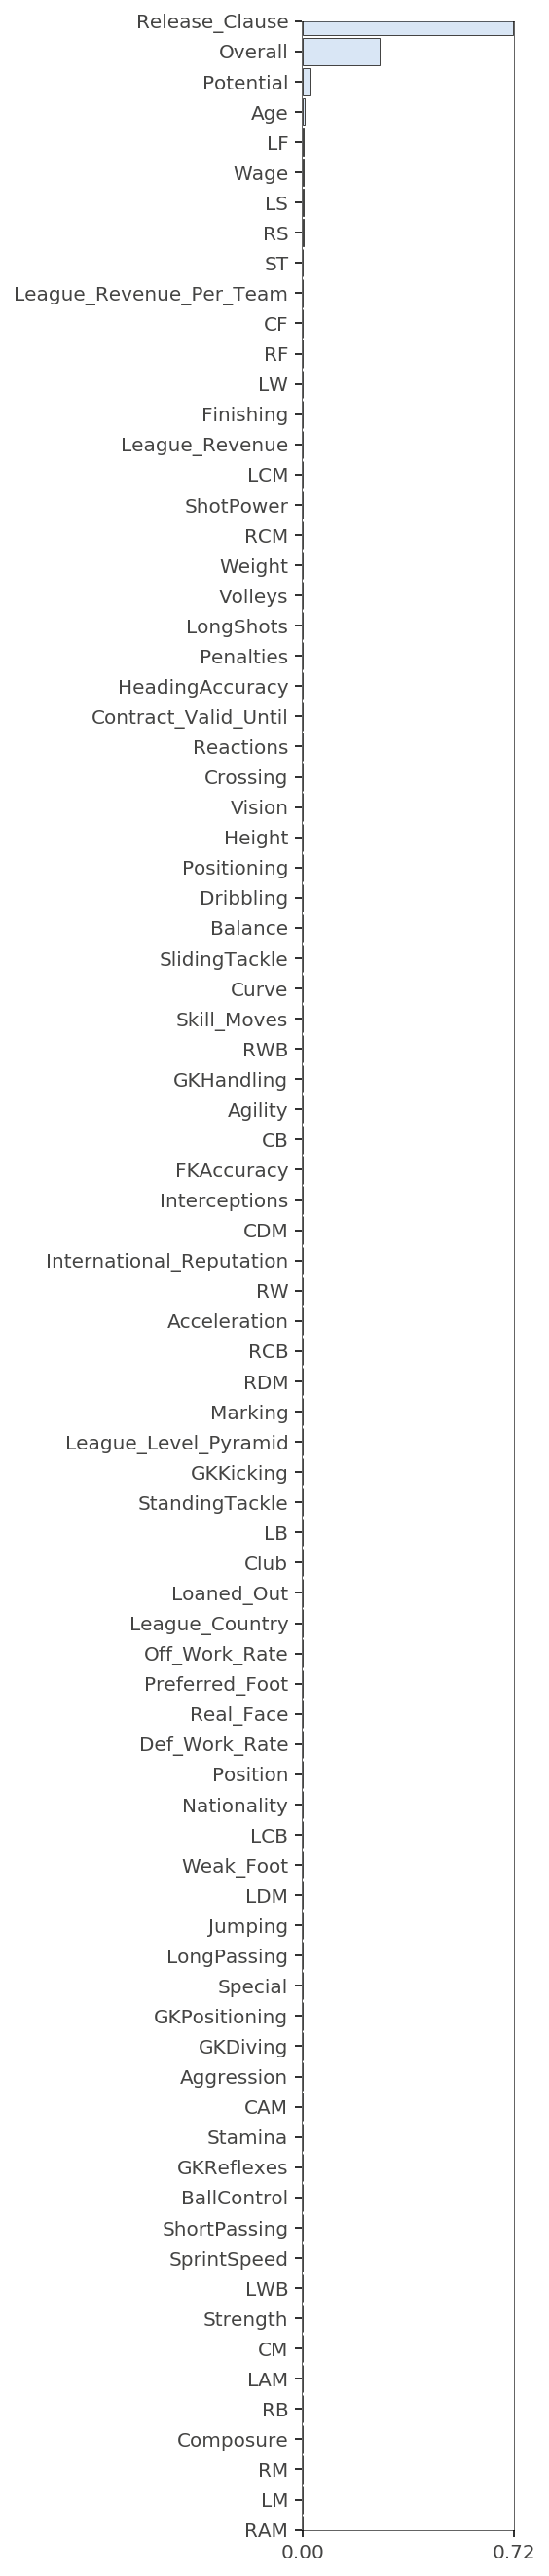

In [13]:
# original feature importance
imp = importances(pipeline, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [14]:
X_train.head()

,Age,Nationality,Overall,Potential,Club,Wage,Special,Preferred_Foot,International_Reputation,Weak_Foot,...,GKPositioning,GKReflexes,Release_Clause,League_Country,League_Level_Pyramid,League_Revenue,League_Revenue_Per_Team,Loaned_Out,Off_Work_Rate,Def_Work_Rate
11068,19,59,64,79,214,0.006,1662,2,1.0,4.0,...,12.0,6.0,NaN,15,2.0,608.0,33.8,1,2,2
9964,31,46,65,65,277,0.004,1628,2,1.0,4.0,...,6.0,7.0,0.831,12,4.0,106.0,4.4,0,0,2
12311,22,9,63,67,210,0.002,1533,0,1.0,3.0,...,7.0,14.0,0.610,3,1.0,179.0,17.9,0,2,2
5979,27,121,69,69,357,0.005,1826,2,1.0,3.0,...,8.0,16.0,1.500,22,1.0,152.0,9.5,0,0,2
11561,27,130,64,64,445,0.003,1781,0,1.0,3.0,...,16.0,9.0,0.831,12,3.0,171.0,7.1,0,2,2


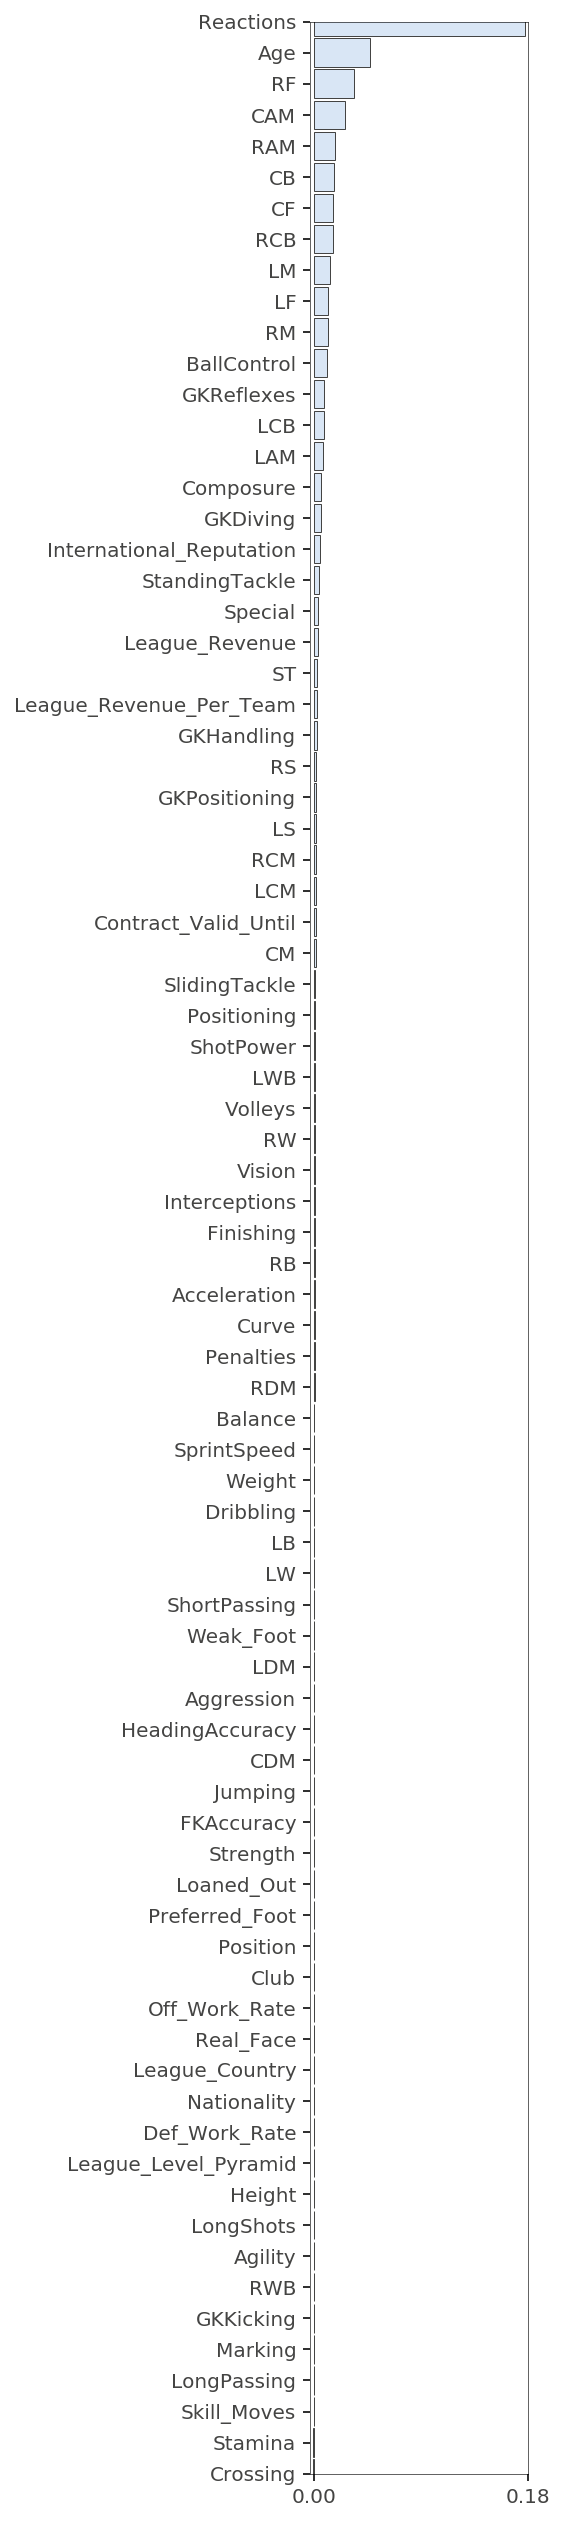

In [15]:
# # feature importance after dropping overall, release clause, and potential

df_drop = df.drop(['Overall', 'Release_Clause', 'Potential', 'Wage'], axis=1)
cat_col = ['Nationality', 'Club', 'Preferred_Foot', 'Off_Work_Rate', 
           'Def_Work_Rate', 'Real_Face', 'Position', 'Loaned_Out', 'League_Country', 'League_Country']

numerical_col = list(set(df_drop.columns) - set(cat_col))
numerical_col.remove('Value')
df_drop[cat_col] = df_drop[cat_col].fillna(value='NA')  # fill na for categorical features
le = preprocessing.LabelEncoder()
for c in cat_col:
    df_drop[c] = le.fit_transform(df_drop[c])
y = df_drop['Value']
X = df_drop.drop('Value',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
pipeline = make_pipeline(regressor)
pipeline.fit(X_train,y_train)
median_absolute_error(y_true=y_test,y_pred=y_pred)

imp = importances(pipeline, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [16]:
X_test.head()

,Age,Nationality,Club,Special,Preferred_Foot,International_Reputation,Weak_Foot,Skill_Moves,Real_Face,Position,...,GKKicking,GKPositioning,GKReflexes,League_Country,League_Level_Pyramid,League_Revenue,League_Revenue_Per_Team,Loaned_Out,Off_Work_Rate,Def_Work_Rate
7541,30,8,378,1740,2,1.0,4.0,2.0,1,2,...,6.0,13.0,10.0,2,1.0,63.0,6.30,0,2,0
101,30,13,315,2278,2,3.0,3.0,3.0,2,0,...,14.0,8.0,11.0,17,1.0,2163.0,108.20,0,0,0
8907,26,77,430,1652,2,1.0,3.0,2.0,1,1,...,7.0,10.0,8.0,17,2.0,276.0,12.50,0,2,2
9352,23,41,159,1720,2,1.0,3.0,3.0,1,23,...,12.0,12.0,12.0,33,1.0,851.0,38.70,0,0,2
6724,21,138,531,1638,0,1.0,2.0,3.0,1,12,...,8.0,5.0,5.0,29,1.0,4479.0,223.95,0,0,1
